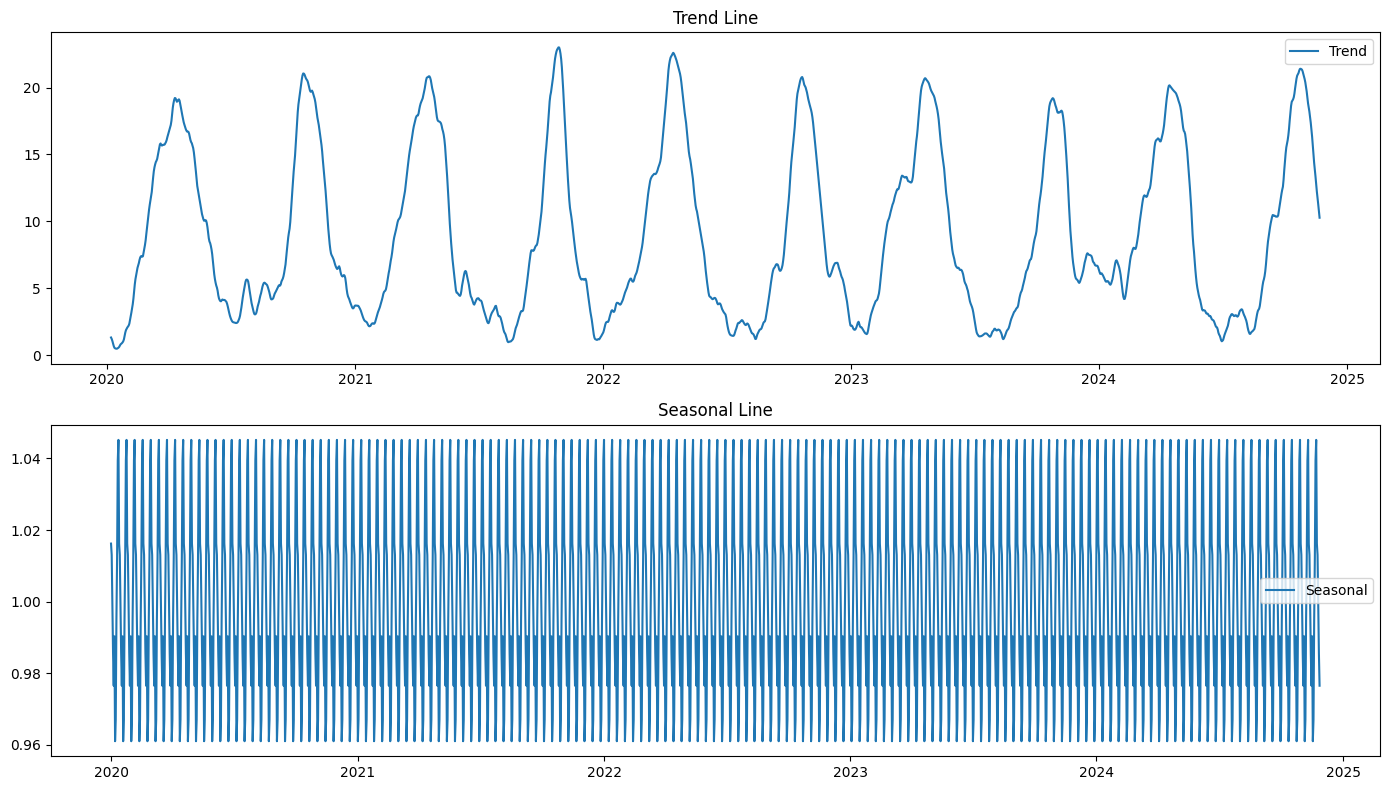

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Lấy dữ liệu từ API
response = requests.get('http://localhost:8000/api/national_outages')
data = response.json()

# Chuyển đổi dữ liệu thành DataFrame
df = pd.DataFrame(data)
df['period'] = pd.to_datetime(df['period'])
df.set_index('period', inplace=True)

# Chọn cột percent_outage để phân tích
series = df['percent_outage']

# Decompose thành trend và seasonal
decomposition = seasonal_decompose(series, model='multiplicative', period=12)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# Vẽ trend và seasonal
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(trend, label='Trend')
plt.title('Trend Line')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Line')
plt.legend()

plt.tight_layout()
plt.show()


Silhouette Score: 0.5880583205665249


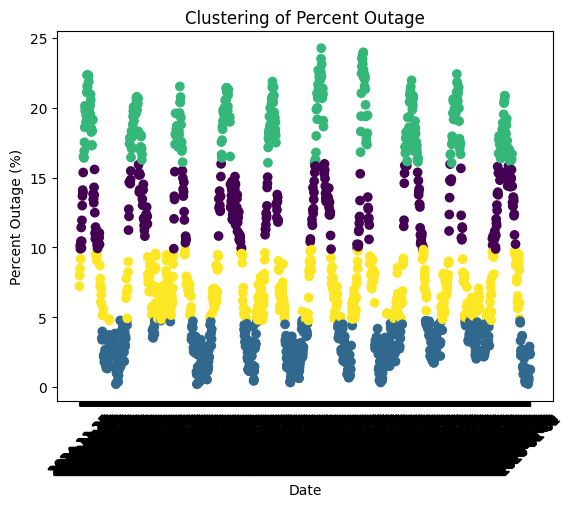

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Giả sử bạn đã lấy dữ liệu từ API và chuyển sang DataFrame
response = requests.get('http://localhost:8000/api/national_outages')
data = response.json()

# Tạo DataFrame
df = pd.DataFrame(data)

# Chọn cột "percent_outage" để phân cụm
X = df[["percent_outage"]]

# Chuẩn hóa dữ liệu nếu cần
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0)
df["cluster"] = kmeans.fit_predict(X_scaled)

df.to_csv('outage_clusters.csv', index=False)


# Tính chỉ số Silhouette để đánh giá mức độ phù hợp
silhouette_avg = silhouette_score(X_scaled, df["cluster"])
print(f"Silhouette Score: {silhouette_avg}")

# Trực quan hóa kết quả phân cụm
plt.scatter(df["period"], df["percent_outage"], c=df["cluster"])
plt.xlabel("Date")
plt.ylabel("Percent Outage (%)")
plt.title("Clustering of Percent Outage")
plt.xticks(rotation=45)
plt.show()




In [5]:
# Đọc file dữ liệu từ KMeans clustering
df = pd.read_csv('outage_clusters.csv')

# Chuyển đổi cột 'period' thành định dạng chuỗi để dễ xử lý
df['period'] = pd.to_datetime(df['period']).dt.strftime('%Y-%m-%d')

# Thêm cột 'year' từ cột 'period'
df['year'] = pd.to_datetime(df['period']).dt.year

# Đặt lại 'cluster' theo các mức độ mô tả cụ thể (mapping cho 'season')
df['season'] = df['cluster'].map({
    0: 'Very low', 
    1: 'Low', 
    2: 'Medium', 
    3: 'High'
})

# Tính số ngày trong từng mùa của mỗi năm
season_counts = df.groupby(['year', 'season']).size().unstack(fill_value=0)

# Chuyển đổi dữ liệu thành JSON-like dictionary
season_counts = season_counts.reset_index()
season_counts_dict = season_counts.to_dict(orient='records')

# Lưu kết quả ra file CSV
season_counts.to_csv('season_counts.csv', index=False)

# In dữ liệu để kiểm tra
print("Season Counts DataFrame:")
print(season_counts)

print("\nJSON-like Data:")
print(season_counts_dict)


Season Counts DataFrame:
season  year  High  Low  Medium  Very low
0       2020   108  119      78        61
1       2021    87  155      80        43
2       2022   105  129      67        64
3       2023   107  121      66        71
4       2024    79  103      78        72

JSON-like Data:
[{'year': 2020, 'High': 108, 'Low': 119, 'Medium': 78, 'Very low': 61}, {'year': 2021, 'High': 87, 'Low': 155, 'Medium': 80, 'Very low': 43}, {'year': 2022, 'High': 105, 'Low': 129, 'Medium': 67, 'Very low': 64}, {'year': 2023, 'High': 107, 'Low': 121, 'Medium': 66, 'Very low': 71}, {'year': 2024, 'High': 79, 'Low': 103, 'Medium': 78, 'Very low': 72}]


In [22]:
import datetime
SCHEDULE_FILE = "schedule_time.txt"
def get_schedule_time():
    try:
        with open(SCHEDULE_FILE, "r") as file:
            time_str = file.read().strip()
            hour, minute = map(int, time_str.split(":"))
            message = f"Schedule time read from file: {hour:02d}:{minute:02d}"
            print(message)
            # append_to_history(message)
            return datetime.time(hour=hour, minute=minute)
    except Exception as e:
        error_message = f"Error reading schedule time: {e}"
        print(error_message)
        return datetime.time(hour=22, minute=15)

now = datetime.datetime.now()
scheduled_time = get_schedule_time()
target_time = datetime.datetime.combine(now.date(), scheduled_time)

print(now)
print(scheduled_time)
print(target_time)

if now > target_time:
    target_time += datetime.timedelta(days=1)

print(target_time)
sleep_duration = (target_time - now).total_seconds()
print(sleep_duration)
print(f"Next clustering scheduled at: {target_time}")

print(f"[{datetime.datetime.now()}] Clustering completed.")

Schedule time read from file: 23:30
2024-11-29 23:40:42.218352
23:30:00
2024-11-29 23:30:00
2024-11-30 23:30:00
85757.781648
Next clustering scheduled at: 2024-11-30 23:30:00
[2024-11-29 23:40:42.219355] Clustering completed.


In [10]:
import numpy as np
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime

# Lấy dữ liệu từ API
def get_data_from_api():
    url = 'http://localhost:8000/api/national_outages'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data)
    else:
        raise Exception("Không thể lấy dữ liệu từ API")

# Lấy dữ liệu từ API
df = get_data_from_api()

# df.columns

# Chuyển đổi cột 'period' sang kiểu datetime
df['date'] = pd.to_datetime(df['period'])
df = df.sort_values('date')


# # Tính toán các đặc trưng: trung bình 7 ngày trước
df['avg_outage_7d'] = df['outage'].rolling(window=7).mean()

df.columns
df.head

# df['avg_percent_outage_7d'] = df['percent_outage'].rolling(window=7).mean()

# # Xóa các dòng không đủ dữ liệu (vì đang tính rolling mean)
# df = df.dropna()

# # Tạo dữ liệu huấn luyện
# X = df[['avg_outage_7d', 'avg_percent_outage_7d']].values
# y = df['percent_outage'].values

# # Huấn luyện mô hình hồi quy tuyến tính
# model = LinearRegression()
# model.fit(X, y)

# # Dự đoán tỉ lệ mất điện cho ngày tiếp theo
# last_row = df.iloc[-1]
# next_day_features = np.array([[last_row['avg_outage_7d'], last_row['avg_percent_outage_7d']]])
# predicted_percent_outage = model.predict(next_day_features)[0]
# predicted_date = last_row['date'] + pd.Timedelta(days=1)

# # Kết quả dự đoán
# print(f"Ngày dự đoán: {predicted_date.strftime('%Y-%m-%d')}")
# print(f"Tỉ lệ mất điện dự đoán: {predicted_percent_outage:.2f}%")

# # Vẽ đồ thị các tỉ lệ mất điện
# plt.figure(figsize=(10, 6))
# plt.plot(df['date'], df['percent_outage'], label='Tỉ lệ mất điện thực tế', marker='o')
# plt.axvline(x=predicted_date, color='r', linestyle='--', label='Ngày dự đoán')
# plt.scatter(predicted_date, predicted_percent_outage, color='r', label=f'Dự đoán: {predicted_percent_outage:.2f}%')
# plt.xlabel('Ngày')
# plt.ylabel('Tỉ lệ mất điện (%)')
# plt.title('Dự đoán tỉ lệ mất điện hạt nhân')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Hiển thị kết quả dưới dạng DataFrame
# df_result = pd.DataFrame({
#     'date': df['date'].dt.strftime('%Y-%m-%d').tolist() + [predicted_date.strftime('%Y-%m-%d')],
#     'percent_outage': df['percent_outage'].round(2).tolist() + [round(predicted_percent_outage, 2)],
# })

# # Lưu kết quả vào file CSV
# output_file = "outage_predictions.csv"
# df_result.to_csv(output_file, index=False)
# print(f"Kết quả đã được lưu vào file {output_file}")

# df_result


<bound method NDFrame.head of         id      period  capacity   outage  percent_outage capacity_units  \
1800  1801  2020-01-01   99321.1  1222.50            1.23      megawatts   
1799  1800  2020-01-02   99321.1  2357.02            2.37      megawatts   
1798  1799  2020-01-03   99321.1  2304.64            2.32      megawatts   
1797  1798  2020-01-04   99321.1  2873.41            2.89      megawatts   
1796  1797  2020-01-05   99321.1  2592.61            2.61      megawatts   
...    ...         ...       ...      ...             ...            ...   
4        5  2024-12-01   99177.2  5044.22            5.09      megawatts   
3        4  2024-12-02   99177.2  5030.27            5.07      megawatts   
2        3  2024-12-03   99177.2  6132.05            6.18      megawatts   
1        2  2024-12-04   99177.2  6142.65            6.19      megawatts   
0        1  2024-12-05   99177.2  8142.36            8.21      megawatts   

     outage_units percent_outage_units       date  avg_ou